In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
import tqdm
import missingno as mn

# Visualization libs
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

palette = sns.hls_palette(8, l=0.7, s=.8)
sns.set(rc={"figure.figsize": (6, 6)}, palette=palette)
sns.set_style("whitegrid")
mpl.rcParams['figure.figsize'] = (10, 5)

In [2]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor

**Обязательное**

1. Предскажите цены на недвижимость с помощью регрессии. Данные — дататасет House Prices (train.csv) с kaggle.

2. Данных немного, поэтому используйте 10-fold кросс-валидацию, чтобы оценить качество моделей.

3. Постройте случайный лес, выведите важность признаков.

4. Обучите стекинг как минимум 3х моделей, используйте хотя бы 1 линейную модель и 1 нелинейную.

5. Для валидации модели 2-го уровня используйте отдельный hold-out датасет, как на занятии.

6. Покажите, что использование ансамблей моделей действительно улучшает качество (стекинг vs другие модели сравнивать на hold-out).

Формат сдачи

Jupyter-notebook с кодом, комментариями и графиками

## Предобработка данных

Сразу отделим target-столбец. Соединим train и test наборы в один, чтобы обработать их фичи, после этого разделим их обратно.

In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

y = train_df.SalePrice
train_df.drop('SalePrice', axis=1, inplace=True)

In [37]:
# Сохраним информацию о лейблах, чтобы было откуда восстановить
label_encoders = {}

def concat_datasets(train, test):
    trn = train.copy()
    tst = test.copy()
    trn['is_test'] = 0
    tst['is_test'] = 1
    return pd.concat([trn, tst])

def split_datasetss(df):
    train = df[df['is_test'] == 0].drop('is_test', axis=1)
    test = df[df['is_test'] == 1].drop('is_test', axis=1)
    return (train, test)

def preprocess_data(df):
    cat_features = [] # ('YearBuilt', 'YearRemodAdd')
    set_features = (
        'MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
        'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
        'BldgType', 'HouseStyle',
        'OverallQual', 'OverallCond',
        'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
        'ExterQual', 'ExterCond', 'Foundation',
        'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
        'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional',
        'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
        'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition'
    )
    fill_zeroes = (
        'MasVnrArea', 'GarageCars',
        'BsmtFinSF1', 'BsmtFinSF2',
        'BsmtUnfSF', 'TotalBsmtSF',
        'BsmtFullBath', 'BsmtHalfBath',
        'GarageArea'
    )
    
    for col in cat_features:
        df[col] = df[col].astype(str)

    for col in set_features:
        label = LabelEncoder()
        label_encoders[col] = label
        values = list(df[col].values)
        label.fit(values)
        df[col] = label.transform(values)
    
    for col in fill_zeroes:
        df[col] = df[col].fillna(0)

    features_to_drop = ['Id', 'LotFrontage', 'GarageYrBlt']

    return df.drop(features_to_drop, axis=1)

In [5]:
df = concat_datasets(train_df, test_df)
df = preprocess_data(df)
X, X_test = split_datasetss(df)

## Создаём hold-out датасет

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

## Случайный лес
Строим случайный лес и смотрим на важность признаков

In [7]:
rfr = RandomForestRegressor(n_estimators=10, random_state=0)
rfr.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [8]:
rfr.score(X_val, y_val)

0.88915720239831064

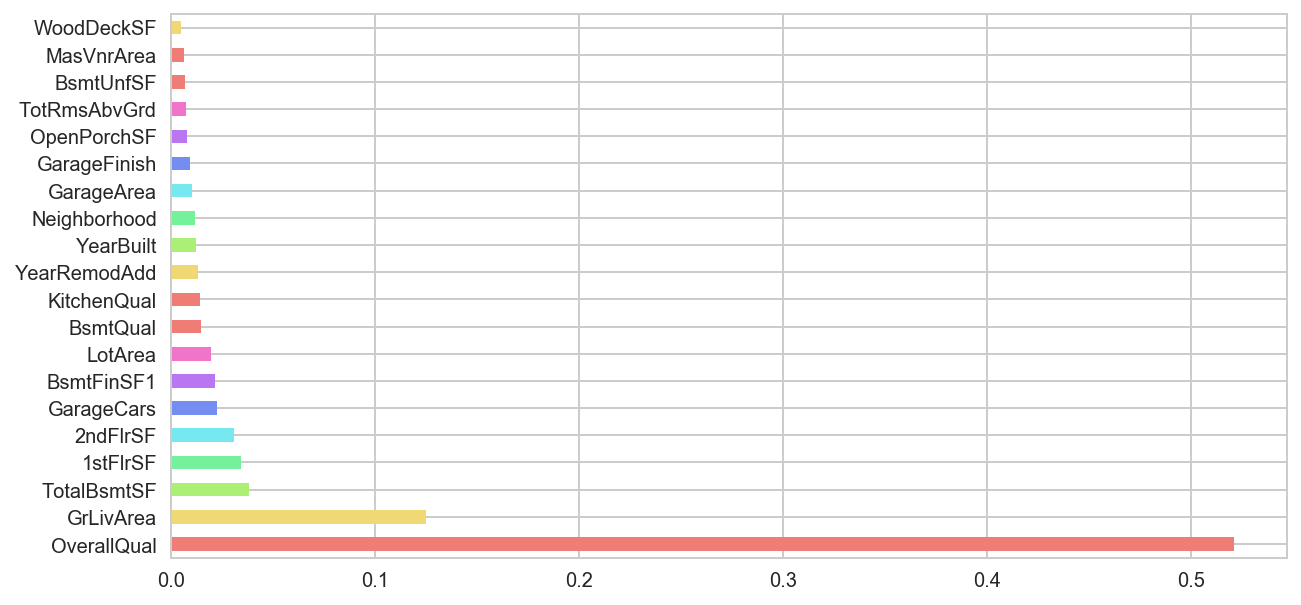

In [9]:
feat_imp = pd.Series(rfr.feature_importances_, index=X_train.columns)
feat_imp.sort_values(ascending=False).iloc[:20].plot(kind='barh', figsize=(10, 5))

## Делаем стекинг

Инициализируем модели первого уровня

In [26]:
models = [
    ['rf_pred', RandomForestRegressor(n_estimators=10, random_state=0)],
    ['lin_pred', LinearRegression()],
    ['dtree_pred', DecisionTreeRegressor(max_depth=10, random_state=0)],
    ['lasso', Lasso()]
]

Далее получаем мета-фичи на основе этих моделей

In [27]:
def get_meta_feature(model, stack_cv, X_train, y_train, X_test):
    meta_train = np.zeros_like(y_train, dtype=float)
    meta_test = np.zeros((X_test.shape[0], ), dtype=float)

    for train_ind, test_ind in stack_cv.split(X_train, y_train):
        model.fit(X_train.iloc[train_ind], y_train.iloc[train_ind])
        meta_train[test_ind] = model.predict(X_train.iloc[test_ind])
        meta_test += model.predict(X_test)
    return meta_train, meta_test / stack_cv.n_splits

In [29]:
def stacking(models, X_train, y_train, X_test):
    meta_train = []
    meta_test = []
    col_names = []

    stack_cv = KFold(n_splits=10, shuffle=False, random_state=42)

    for name, model in tqdm.tqdm(models):
        meta_tr, meta_te = get_meta_feature(model, stack_cv, X_train, y_train, X_test)
        meta_train.append(meta_tr)
        meta_test.append(meta_te)
        col_names.append(name)

    X_meta_train = pd.DataFrame(np.stack(meta_train, axis=1), columns=col_names)
    X_meta_test = pd.DataFrame(np.stack(meta_test, axis=1), columns=col_names)

    return X_meta_train, X_meta_test

In [30]:
X_meta_train, X_meta_test = stacking(models, X_train, y_train, X_val)

100%|██████████| 4/4 [00:01<00:00,  2.41it/s]


Инициализируем и обучаем модель второго уровня

In [31]:
meta_model = XGBRegressor()
meta_model.fit(X_meta_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [32]:
meta_score = meta_model.score(X_meta_test, y_val)
meta_score

0.89409814845022784

Теперь сравним качество стекинга и отдельных моделей

In [33]:
scores = [
    ['meta-model', meta_score]
]
for name, model in tqdm.tqdm(models):
    model.fit(X_train, y_train)
    scores.append([name, model.score(X_val, y_val)])

scores_df = pd.DataFrame(scores, columns=['name', 'score']).set_index('name')
scores_df

100%|██████████| 4/4 [00:00<00:00, 21.02it/s]


,score
name,
meta-model,0.894098
rf_pred,0.889157
lin_pred,0.845688
dtree_pred,0.742597
lasso,0.845712


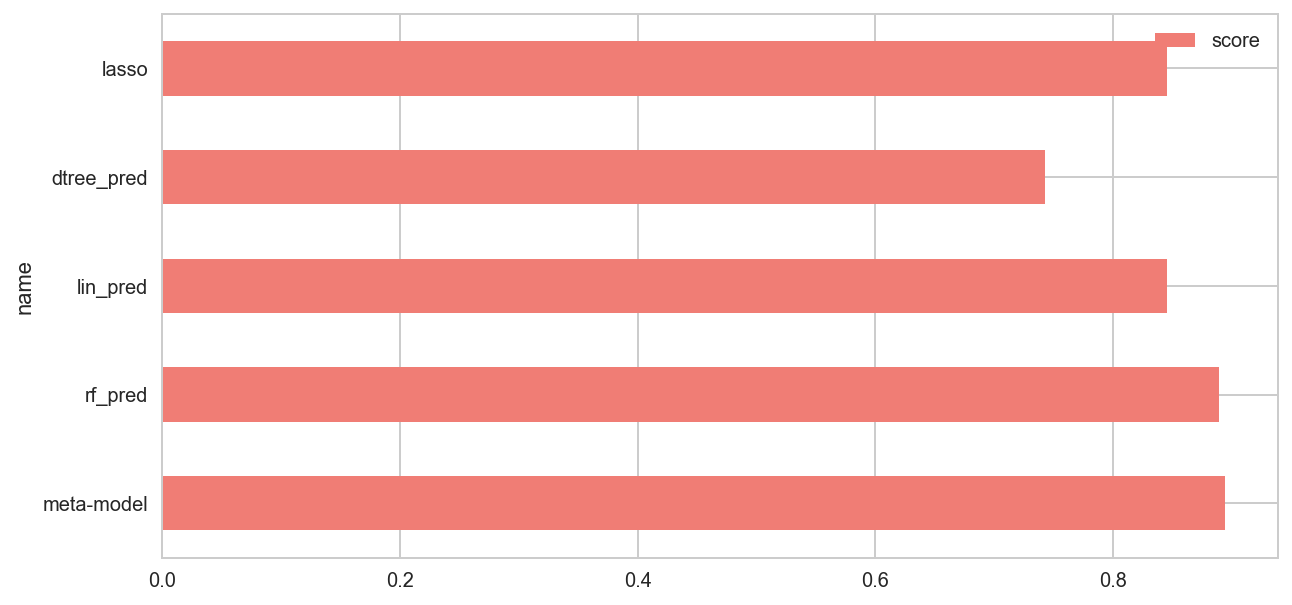

In [34]:
scores_df.plot(kind='barh')

Делаем предсказания на финальный тест, используя стекинг

In [35]:
X_meta_train, X_meta_test = stacking(models, X_train, y_train, X_test)

meta_model = XGBRegressor()
meta_model.fit(X_meta_train, y_train)

y_pred = meta_model.predict(X_meta_test)

predictions = pd.DataFrame(
    list(zip(test_df['Id'], y_pred)),
    columns=['Id', 'SalePrice']
)
predictions.shape

100%|██████████| 4/4 [00:01<00:00,  2.59it/s]


(1459, 2)

In [36]:
predictions.to_csv('submission_stacking.csv', index=False)